In [1]:
# split train and test set of math symbols
import json
import random
import os

random.seed(777)

symbol_images_dir = 'symbol_images/'
terminals = ['+', '-', 'times', 'div', '(', ')', '!'] + list(map(str, list(range(10))))
sym_train_set = {}
sym_val_set = {}
sym_test_set = {}
for tok in terminals:
    imgs = os.listdir(symbol_images_dir + tok)
    random.shuffle(imgs)
    n_train = int(len(imgs) * 0.75)
    n_val = int(len(imgs) * 0.05)
    sym_train_set[tok] = sorted(imgs[:n_train])
    sym_val_set[tok] = sorted(imgs[n_train:n_train+n_val])
    sym_test_set[tok] = sorted(imgs[n_train+n_val:])
    print(tok, len(imgs))
json.dump(sym_train_set, open('sym_train.json', 'w'))
json.dump(sym_val_set, open('sym_val.json', 'w'))
json.dump(sym_test_set, open('sym_test.json', 'w'))

+ 25112
- 33997
times 3251
div 868
( 14294
) 14355
! 1300
0 6914
1 26520
2 26141
3 10909
4 7396
5 3545
6 3118
7 2909
8 3068
9 3737


In [2]:
from domain import SYM2PROG
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../semantics/dreamcoder")

from jointer import AST
import os
import random
from PIL import Image
import json
random.seed(777)

class Iterator:
    def __init__(self, l, shuffle=True):
        if shuffle: 
            random.shuffle(l)
        self.list = l
        self.current = -1
        self.shuffle = shuffle
    
    def next(self):
        self.current += 1
        if self.current == len(self.list):
            self.current = 0
            if self.shuffle:
                random.shuffle(self.list)
        return self.list[self.current]

splits = ['train', 'val', 'test']
split2sym = {}
for split in splits:
    sym_set = {k:Iterator(v) for k,v in json.load(open('sym_%s.json'%split)).items()}
    split2sym[split] = sym_set
    

def render_img(img_paths):
    images = [Image.open(symbol_images_dir + x) for x in img_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im

def generate_img_paths(tokens, sym_set):
    img_paths = []
    for tok in tokens:
        if tok == '*': tok = 'times'
        if tok == '/': tok = 'div'
        
        img_name = sym_set[tok].next()
        img_paths.append(os.path.join(tok, img_name))   
        
    return img_paths

In [3]:
min_num = 0
max_num = 10
num_list = list(map(str, range(min_num, max_num)))
nonzero_num_list = [x for x in num_list if x != '0']
op_list = ['+', '-', '*', '/']
lps = '('
rps = ')'

print(num_list)
print(op_list, lps, rps)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['+', '-', '*', '/'] ( )


In [4]:
op2precedence = {'+': 2, '-': 2, '*': 3, '/': 3, '!': 4}
op2arity = {'+': 2, '-': 2, '*': 2, '/': 2, '!': 1}

def parse_infix(expr):
    values = []
    operators = []
    
    head = [-1] * len(expr)
    mask = [1] * len(expr)
    for (i,sym) in enumerate(expr):
        if sym.isdigit():
            values.append(i)
        elif sym == lps:
            operators.append(i)
        elif sym == rps:
            while expr[operators[-1]] != lps:
                op = operators.pop()
                for _ in range(op2arity[expr[op]]):
                    head[values.pop()] = op
                values.append(op)
            i_lps = operators[-1]
            i_rps = i
            head[i_lps] = op
            head[i_rps] = op
            mask[i_lps] = 0
            mask[i_rps] = 0
            operators.pop()
        else:
            while len(operators) > 0 and expr[operators[-1]] != lps and \
                op2precedence[expr[operators[-1]]] >= op2precedence[sym]:
                op = operators.pop()
                for _ in range(op2arity[expr[op]]):
                    head[values.pop()] = op
                values.append(op)
            operators.append(i)

    while len(operators) > 0:
        op = operators.pop()
        for _ in range(op2arity[expr[op]]):
            head[values.pop()] = op
        values.append(op)

    root_op = values.pop()
    head[root_op] = -1
    assert len(values) == 0

    return head, mask

def parse_prefix(expr):
    head = [-1] * len(expr)
    arity = [op2arity.get(x, 0) for x in expr]
    for i in range(len(expr)):
        if i == 0: 
            head[i] = -1
            continue
        for j in range(i-1, -1, -1):
            if arity[j] > 0:
                break
        head[i] = j
        arity[j] -= 1
        #print(i, head, arity)

    return head

def flatten(expr):
    if len(expr) == 1:
        return expr
    return [y for x in expr for y in flatten(x)]

def prefix2infix(prefix):
    prefix = list(prefix)
    values = []
    while len(prefix) > 0:
        sym = prefix.pop()
        if sym.isdigit():
            values.append([sym])
        else:
            arity = op2arity[sym]
            precedence = op2precedence[sym]
            
            left = values.pop()
            right = values.pop() if arity == 2 else []
            """
            add parenthesis when:
            (1) left is a compound expression and its operator's precedence < the current operator
            (2) right is a compound expression and its operator's precedence <= the current operator
            here we assume that the operator is left-associative.
            """
            if len(left) > 1 and op2precedence[left[1]] < precedence:
                left = [lps] + left + [rps]
            if len(right) > 1 and op2precedence[right[1]] <= precedence:
                right = [lps] + right + [rps]
                
            new_value = [left, sym, right]
            values.append(new_value)
    
    infix = ''.join(flatten(values.pop()))
    assert len(values) == 0
    return infix

from collections import namedtuple
Parse = namedtuple('Parse', 'sentence head mask')
def eval_expr(expr, head, mask=None):
    if mask is None: mask = [1] * len(expr)
    ast = AST(Parse(expr, head, mask), SYM2PROG)
    return ast.res(), ast.res_all()
    
def eval_expr_by_eval(expr):
    expr_for_eval = []
    for symbol in expr:
        if symbol == '!':
            expr_for_eval[-1] = 'math.factorial(' + expr_for_eval[-1] + ')'
        elif symbol == '/':
            expr_for_eval.append('//')
        else:
            expr_for_eval.append(symbol)
#     try:
#         res = eval("".join(expr_for_eval))
#     except OverflowError:
#         res = None
    res = eval("".join(expr_for_eval))
    return res



expr = '6*(5-2)!'
head, mask = parse_infix(expr)
res = eval_expr(expr, head, mask)
print(expr, res, head)

expr = '/+64-31'
head = parse_prefix(expr)
res = eval_expr(expr, head)
print(expr, res, head)

expr = prefix2infix(expr)
head, mask = parse_infix(expr)
res = eval_expr(expr, head, mask)
print(expr, res, head)

6*(5-2)! (36, [6, 36, None, 5, 3, 2, None, 6]) [1, -1, 4, 4, 7, 4, 4, 1]
/+64-31 (5, [5, 10, 6, 4, 2, 3, 1]) [-1, 0, 1, 1, 0, 4, 4]
(6+4)/(3-1) (5, [None, 6, 10, 4, None, 5, None, 3, 2, 1, None]) [2, 2, 5, 2, 2, -1, 8, 8, 5, 8, 8]


In [5]:
from itertools import product
from tqdm import tqdm

def enumerate_expression(n_op):
    if n_op == 0:
        return [[x] for x in num_list]
    
    expressions = []
    
    arity = 1
    ops = [op for op in op_list if op2arity[op] == arity]
    inputs = enumerate_expression(n_op-1)
    expressions.extend(product(ops, inputs))
    
    arity = 2
    ops = [op for op in op_list if op2arity[op] == arity]
    inputs = []
    for i in range(n_op):
        input_1 = enumerate_expression(i)
        input_2 = enumerate_expression(n_op - 1 - i)
        inputs.extend(product(input_1, input_2))
    expressions.extend(product(ops, inputs))
    
    expressions = [flatten(x) for x in expressions]
    return expressions

def sample_expression(n_op, n_instances, min_value=0, max_value=float('inf')):
    def sample(n_op):
        if n_op == 0:
            return [random.choice(num_list)]
        op = random.choice(op_list)
        if op2arity[op] == 1:
            return [op] + sample(n_op-1)
        else:
            i = random.randint(0, n_op-1)
            j = n_op - 1 - i
            return [op] + sample(i) + sample(j)
    
    expressions = []
    with tqdm(total=n_instances) as pbar:
        while len(expressions) < n_instances:
            expr = sample(n_op)
            if expr in expressions:
                continue
            head = parse_prefix(expr)
            res, res_all = eval_expr(expr, head)
            if res is not None:
                max_res = max(res_all)
                if max_res >= min_value and max_res <= max_value:
                    expressions.append(expr)
                    pbar.update(1)
    return expressions

def generate_expression(n_op, n_instances, min_value=0, max_value=float('inf')):
    if n_op <= 2:
        expressions = []
        for expr in enumerate_expression(n_op):
            head = parse_prefix(expr)
            res, res_all = eval_expr(expr, head)
            if res is not None:
                max_res = max(res_all)
                if max_res >= min_value and max_res <= max_value:
                    expressions.append(expr)
    else:
        assert n_instances is not None
        expressions = sample_expression(n_op, n_instances, min_value, max_value)
    random.shuffle(expressions)
    expressions = expressions[:n_instances]
    
    temp = []
    for expr in expressions:
        expr = prefix2infix(expr)
        head, mask = parse_infix(expr)
        res, res_all = eval_expr(expr, head, mask)
        if res is not None:
            temp.append((expr, head, mask, res, res_all))
    
    return temp

In [6]:
expressions = generate_expression(2, 100000)
print(len(expressions))
print(len([x for x in expressions if x[3] != 0]))
print(len([x for x in expressions if x[3] == 0]))
print(expressions[:3])

29970
22261
7709
[('(8+2)/9', [2, 2, 5, 2, 2, -1, 5], [0, 1, 1, 1, 0, 1, 1], 2, [None, 8, 10, 2, None, 2, 9]), ('3+(9-4)', [1, -1, 4, 4, 1, 4, 4], [1, 1, 0, 1, 1, 1, 0], 8, [3, 8, None, 9, 5, 4, None]), ('1/6+5', [1, 3, 1, -1, 3], [1, 1, 1, 1, 1], 6, [1, 1, 6, 6, 5])]


In [7]:
random.seed(12306)
max_op = 20
max_train_op = 10
n_train = int(1e3)
n_test = n_train
n_val = int(n_train / 10)
train_exprs = []
val_exprs = []
test_exprs = []

max_value_train = 100
max_value_test = 10000

for n_op in range(max_op + 1):
    if n_op > max_train_op:
        n_train = 0
    expressions = generate_expression(n_op, n_train + n_test, max_value=max_value_train)
    
    train_exprs.append(expressions[:n_train])
    val_exprs.append(expressions[:min(n_val, n_train)] + expressions[n_train:n_train+n_val])
    test_exprs.append(expressions[:n_train + n_test])
    
    expressions = generate_expression(n_op, n_test, min_value=max_value_train+1, max_value=max_value_test)
    val_exprs[-1].extend(expressions[:n_val])
    test_exprs[-1].extend(expressions)

    print(n_op, len(train_exprs[-1]), len(val_exprs[-1]), len(test_exprs[-1]))
    
split2exprs = {'train': train_exprs, 'val': val_exprs, 'test': test_exprs}
print([(k, sum([len(x) for x in v])) for k, v in split2exprs.items()])

0 10 10 10
1 390 100 390


  0%|          | 0/1000 [00:00<?, ?it/s]

2 1000 300 2740


100%|██████████| 2000/2000 [00:00<00:00, 12248.09it/s]


3 1000 300 3000


100%|██████████| 2000/2000 [00:00<00:00, 10603.11it/s]


4 1000 300 3000


 53%|█████▎    | 1053/2000 [00:00<00:00, 10522.71it/s]

5 1000 300 3000


 47%|████▋     | 936/2000 [00:00<00:00, 9345.86it/s]

6 1000 300 3000


 39%|███▉      | 788/2000 [00:00<00:00, 7853.38it/s]

7 1000 300 3000


 33%|███▎      | 669/2000 [00:00<00:00, 6686.90it/s]

8 1000 300 3000


 30%|███       | 610/2000 [00:00<00:00, 6095.08it/s]

9 1000 300 3000


100%|██████████| 1000/1000 [00:00<00:00, 5097.03it/s]

10 1000 300 3000



 46%|████▌     | 457/1000 [00:00<00:00, 4565.90it/s]

11 0 200 2000


 44%|████▍     | 438/1000 [00:00<00:00, 4369.88it/s]

12 0 200 2000


 35%|███▍      | 349/1000 [00:00<00:00, 3484.69it/s]

13 0 200 2000


 30%|██▉       | 297/1000 [00:00<00:00, 2963.88it/s]

14 0 200 2000


 30%|██▉       | 295/1000 [00:00<00:00, 2928.03it/s]

15 0 200 2000


 22%|██▏       | 221/1000 [00:00<00:00, 2201.85it/s]

16 0 200 2000


 21%|██▏       | 214/1000 [00:00<00:00, 2119.50it/s]

17 0 200 2000


 17%|█▋        | 172/1000 [00:00<00:00, 1699.68it/s]

18 0 200 2000


 16%|█▌        | 162/1000 [00:00<00:00, 1608.63it/s]

19 0 200 2000


100%|██████████| 1000/1000 [00:01<00:00, 859.32it/s]


20 0 200 2000
[('train', 9400), ('val', 4810), ('test', 47140)]


In [8]:
test_exprs[3][0]

('2/4-(8+6)',
 [1, 3, 1, -1, 6, 6, 3, 6, 6],
 [1, 1, 1, 1, 0, 1, 1, 1, 0],
 0,
 [2, 1, 4, 0, None, 8, 14, 6, None])

In [9]:
split = 'train'
dataset = split2exprs[split][3]
print(len(dataset))
print(dataset[:5])

1000
[('2/4-(8+6)', [1, 3, 1, -1, 6, 6, 3, 6, 6], [1, 1, 1, 1, 0, 1, 1, 1, 0], 0, [2, 1, 4, 0, None, 8, 14, 6, None]), ('7/(7-(2-9))', [1, -1, 4, 4, 1, 7, 7, 4, 7, 7, 4], [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0], 1, [7, 1, None, 7, 7, None, 2, 0, 9, None, None]), ('3*(8/(3/2))', [1, -1, 4, 4, 1, 7, 7, 4, 7, 7, 4], [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0], 12, [3, 12, None, 8, 4, None, 3, 2, 2, None, None]), ('(6+6)*(2*3)', [2, 2, 5, 2, 2, -1, 8, 8, 5, 8, 8], [0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0], 72, [None, 6, 12, 6, None, 72, None, 2, 6, 3, None]), ('8/1-(6+1)', [1, 3, 1, -1, 6, 6, 3, 6, 6], [1, 1, 1, 1, 0, 1, 1, 1, 0], 1, [8, 8, 1, 1, None, 6, 7, 1, None])]


In [10]:
import math

split2dataset = {}
for split in splits:
    sym_set = split2sym[split]
    exprs = split2exprs[split]
    dataset = []
    idx = 0
    for n_op, expr_list in enumerate(exprs):
        if n_op == 0: n_instance = 100
        elif n_op == 1: n_instance = 2
        else: n_instance = 1
            
        if split == 'val':
            n_instance *= 0.1
        for e in expr_list:
            for _ in range(int(math.ceil(n_instance))):
                img_paths = generate_img_paths(e[0], sym_set)
                sample = {'id': '%s_%08d'%(split, idx), 'img_paths':img_paths, 
                      'expr': e[0], 'head': e[1], 'mask': e[2], 'res': e[3], 'res_all': e[4]}
                idx += 1
                dataset.append(sample)
    split2dataset[split] = dataset
    print(split, len(dataset))

train 10780
val 4900
test 48520


In [11]:
from collections import Counter

dataset = split2dataset['train']
print(len([0 for x in dataset if x['res'] != 0]))
res_counts = Counter([x['res'] for x in dataset])
print(sorted(list(res_counts.items())))
print(random.sample(dataset, k=3))

dataset = split2dataset['val']
print(len([0 for x in dataset if x['res'] != 0]))
res_counts = Counter([x['res'] for x in dataset])
print(sorted(list(res_counts.items())))
print(len([0 for x in dataset if x['res'] <= 1000]))
print(len([0 for x in dataset if x['res'] > 1000]))
print(random.sample(dataset, k=3))

7482
[(0, 3298), (1, 1346), (2, 661), (3, 481), (4, 436), (5, 398), (6, 421), (7, 354), (8, 392), (9, 359), (10, 190), (11, 130), (12, 151), (13, 110), (14, 120), (15, 115), (16, 103), (17, 66), (18, 114), (19, 46), (20, 71), (21, 57), (22, 40), (23, 26), (24, 80), (25, 32), (26, 26), (27, 33), (28, 43), (29, 20), (30, 42), (31, 15), (32, 59), (33, 12), (34, 12), (35, 33), (36, 58), (37, 12), (38, 21), (39, 14), (40, 41), (41, 19), (42, 26), (43, 16), (44, 24), (45, 29), (46, 12), (47, 12), (48, 50), (49, 26), (50, 17), (51, 13), (52, 17), (53, 14), (54, 29), (55, 10), (56, 44), (57, 9), (58, 11), (59, 5), (60, 24), (61, 11), (62, 5), (63, 29), (64, 23), (65, 10), (66, 12), (67, 7), (68, 7), (69, 5), (70, 13), (71, 4), (72, 36), (73, 8), (74, 3), (75, 12), (76, 7), (77, 6), (78, 12), (79, 3), (80, 11), (81, 12), (82, 5), (83, 2), (84, 17), (85, 3), (86, 2), (87, 3), (88, 3), (89, 1), (90, 13), (91, 8), (92, 4), (93, 1), (95, 3), (96, 15), (97, 3), (98, 3), (99, 4), (100, 9)]
[{'id': 't

train 10780 100
(3/9+4-7)/(8/(9-6))*(4+6+0+5) [6, 2, 4, 2, 6, 4, 9, 6, 6, 19, 12, 12, 9, 15, 15, 12, 15, 15, 12, -1, 26, 22, 24, 22, 26, 24, 19, 26, 26] 0


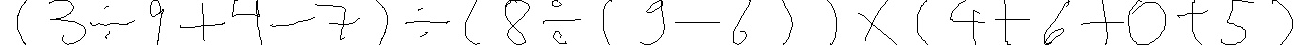

7-(4/(6*2*2)+(5+9)+0) [1, -1, 18, 4, 12, 9, 7, 9, 7, 4, 9, 9, 18, 15, 15, 12, 15, 15, 1, 18, 18] 0


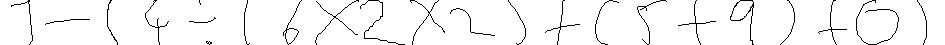

0*5-(7-2)+3 [1, 3, 1, 9, 6, 6, 3, 6, 6, -1, 9] 3


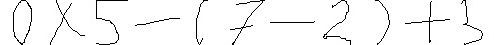

7*9+5/((8/(6/2)*(8*(1/3))-0)/6) [1, 3, 1, -1, 5, 3, 28, 25, 9, 15, 12, 12, 9, 12, 12, 25, 18, 18, 15, 21, 21, 18, 21, 21, 18, 28, 25, 25, 5, 28, 28] 65


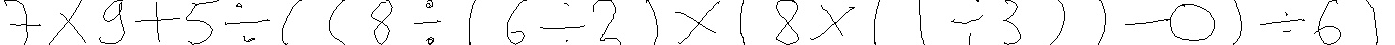

1*(5*3) [1, -1, 4, 4, 1, 4, 4] 15


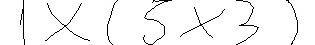

val 4900 9504
0-5+9 [1, 3, 1, -1, 3] 9


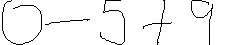

((5+(4+2))*3-(0+4)*4*(9*5)/7)*((5-(3+4))*(4*2-8*9)) [12, 3, 3, 10, 6, 6, 3, 6, 6, 3, 12, 10, 29, 15, 15, 18, 15, 15, 20, 18, 26, 23, 23, 20, 23, 23, 12, 26, 12, -1, 40, 33, 33, 40, 36, 36, 33, 36, 36, 33, 29, 45, 43, 45, 43, 40, 47, 45, 47, 45, 40] 0


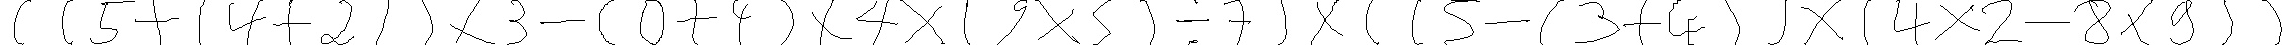

(6+(2+6+2)-0*8+7)/((7-(5-9-4))*(3*3*(4*(0+3)))) [14, 2, 10, 7, 5, 7, 5, 2, 7, 7, 14, 12, 10, 12, 17, 14, 14, -1, 30, 21, 21, 30, 26, 24, 26, 24, 21, 26, 26, 21, 17, 35, 33, 35, 33, 30, 38, 38, 35, 41, 41, 38, 41, 41, 38, 35, 30] 1


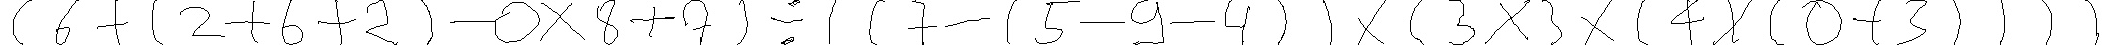

(7+9)/(6+9+(3*7/3+(6-4/8/(0*6+5*1)*1)))+0/8*1*3 [2, 2, 5, 2, 2, 39, 10, 8, 10, 8, 5, 17, 13, 15, 13, 17, 15, 10, 20, 20, 17, 22, 24, 22, 34, 29, 27, 29, 27, 24, 31, 29, 31, 29, 20, 34, 20, 17, 10, -1, 41, 43, 41, 45, 43, 39, 45] 1


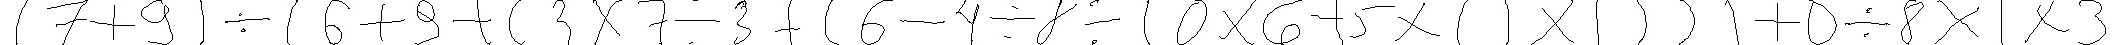

4/1/6*((7+(8-(8-4)))/(9/4))/(6*(8-5*1)/(9*(7*((8+7)*(2*2))))) [1, 3, 1, 5, 3, 27, 20, 9, 9, 20, 12, 12, 9, 15, 15, 12, 15, 15, 12, 9, 5, 23, 23, 20, 23, 23, 20, -1, 38, 30, 38, 33, 33, 30, 35, 33, 35, 33, 27, 41, 41, 38, 44, 44, 41, 51, 48, 48, 51, 48, 48, 44, 54, 54, 51, 54, 54, 51, 44, 41, 38] 4


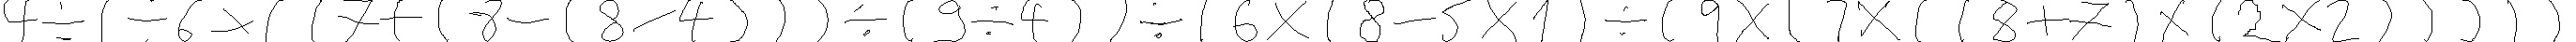

test 48520 9984
9*(8*7)*(0*0) [1, 7, 4, 4, 1, 4, 4, -1, 10, 10, 7, 10, 10] 0


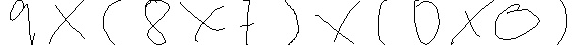

9*(5*(0+(2-2+(4-(3+0+6))-9)))+0/(5/6)*(2-1)+2*1 [1, 29, 4, 4, 1, 7, 7, 4, 24, 10, 12, 10, 24, 15, 15, 12, 20, 18, 20, 18, 15, 20, 20, 15, 7, 24, 24, 7, 4, 43, 31, 37, 34, 34, 31, 34, 34, 29, 40, 40, 37, 40, 40, -1, 45, 43, 45] 2


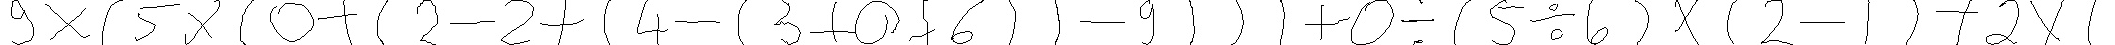

(8+2)/((4+3-8+7-4*(1-4))*(1/6)) [2, 2, 5, 2, 2, -1, 24, 15, 9, 11, 9, 13, 11, 15, 13, 24, 17, 15, 20, 20, 17, 20, 20, 15, 5, 27, 27, 24, 27, 27, 24] 2


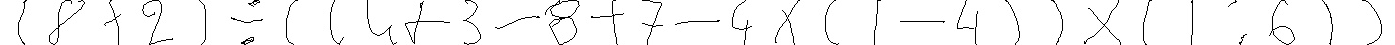

(2/1/4-(9+5-3/6/8+(4*1/6-8)))/(9*(6*(9*9/(5+9+6)))) [6, 2, 4, 2, 6, 4, 29, 17, 9, 11, 9, 17, 13, 15, 13, 11, 15, 6, 24, 20, 22, 20, 24, 22, 17, 24, 24, 17, 6, -1, 32, 32, 29, 35, 35, 32, 40, 38, 40, 38, 35, 45, 43, 45, 43, 40, 45, 45, 40, 35, 32] 0


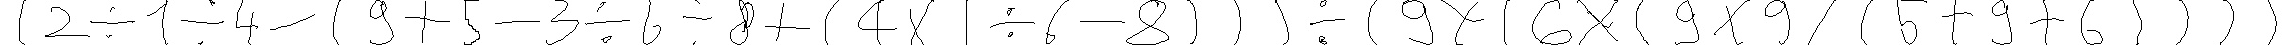

3/2/(9*(5+(6-(1-6*3)+9+4))) [1, 3, 1, -1, 6, 6, 3, 9, 9, 6, 22, 12, 20, 15, 15, 12, 17, 15, 17, 15, 22, 20, 9, 22, 22, 9, 6] 1


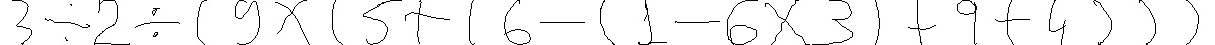

In [12]:
# Visualize data
import numpy as np
for split in splits:
    dataset = split2dataset[split]
    print(split, len(dataset), np.max([x['res'] for x in dataset]))
    for _ in range(5):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']), sample['head'], sample['res'])
        display(img)

In [13]:
train_exprs = {x['expr'] for x in split2dataset['train']}
max_len_train = max([len(x) for x in train_exprs])
for split in ['val', 'test']:
    dataset = split2dataset[split]
    for sample in dataset:
        expr = sample['expr']
        if expr in train_exprs:
            evaluation = 1
        elif len(expr) <= max_len_train:
            max_value = max([x for x in sample['res_all'] if x is not None])
            if max_value <= max_value_train:
                evaluation = 2
            else:
                evaluation = 3
        else:
            max_value = max([x for x in sample['res_all'] if x is not None])
            if max_value <= max_value_train:
                evaluation = 4
            else:
                evaluation = 5
        sample['eval'] = evaluation

In [14]:
counts = sorted(Counter([x['eval'] for x in split2dataset['test']]).items())
total_count = sum([c for _, c in counts])
counts = [(k, round(v/total_count*100, 2)) for k, v in counts]
print(counts)
print(list({x['expr'] for x in split2dataset['test'] if x['eval'] == 3})[:10])

[(1, 22.22), (2, 23.28), (3, 22.5), (4, 15.88), (5, 16.12)]
['(2+2+3)*5+(8+6)*(6/1*6)', '1*(1*0)/(3*7*(6*4))', '5*3/8/(3+3/((4+2)*8*2*(7+2)))', '(3+4*9+6)/(8*(8+1)*5)', '7*(4*7)', '6-9-(7*(5*3)+(7+(6+(4+4))))', '2+7-7*8*6', '(9/4+8)*1*(7/(5+2)+(5+2+(6+6+9)))', '4*8*(3*4*7)', '3*2+1/(4+5)/((5+2*6)*(2/3)*(8/1))']


In [15]:
for split in splits:
    json.dump(split2dataset[split], open('expr_%s.json'%split, 'w'))

(45, 45)


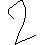

7/1/7-2 = -1.0


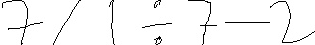

In [16]:
img = Image.open(symbol_images_dir + '2/2_849.jpg')
print(img.size)
display(img)

expr = '7/1/7-2'
img_paths = generate_img_paths(expr, sym_set=sym_set)
img = render_img(img_paths)
print(expr,'=', eval(expr))
display(img)

In [17]:
import json
train_set = json.load(open('expr_train.json'))
val_set = json.load(open('expr_val.json'))

In [18]:
from collections import Counter
def compute_depth(expr):
    depth = 0
    max_depth = 0
    for x in expr:
        if x == lps:
            c = 1
        elif x == rps:
            c = -1
        else:
            c = 0
        depth += c
        if depth > max_depth:
            max_depth = depth
    return max_depth

print(compute_depth('1*2*(1+2*((3+4)+(3-1))'))
ps_depths = [compute_depth(x['expr']) for x in train_set]
print(Counter(ps_depths))

ps_depths = [compute_depth(x['expr']) for x in val_set]
print(Counter(ps_depths))

3
Counter({2: 3398, 1: 3174, 0: 2611, 3: 1326, 4: 240, 5: 31})
Counter({2: 1412, 3: 1274, 1: 989, 4: 624, 0: 425, 5: 144, 6: 27, 7: 4, 8: 1})
